# RT-XFair – Demostració d’explicabilitat en temps real amb dades HELOC

### Introducció
Aquest notebook conté una demostració de tot el procés que forma el RT-XFair per a la selecció de perfils de risc de crèdit utilitzant el conjunt de dades **HELOC** com a dataset de prova.
Es cobriran els següents passos:

1. Càrrega i preprocessament del conjunt de dades HELOC
2. Creació del model amb atenció per característica
3. Entrenament del model
4. Generació d’explicacions en temps real mitjançant Integrated Gradients (IG) i Fusió d’Atenció
5. Mesura de la latència d’inferència i d’explicació
6. Exportació del model per al desplegament 

>Al llarg d’aquest procés, també mesurarem i informarem de mètriques de rendiment clau, incloent-hi la latència i la precisió predictiva.


In [1]:
!pip install torch scikit-learn pandas numpy matplotlib

## Configuració i rutes del projecte

Primer configurem les rutes relatives a la ubicació del notebook:

- `PROJ_ROOT` → arrel del projecte (`rtxfair/`)  
- `DEMO_DIR`  → directori del notebook (`DEMO/`)  
- `DATA_DIR`  → carpeta de datasets (`DEMO/datasets/`)  


In [2]:
import os, sys, time, math
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DEMO_DIR   = Path.cwd()
PROJ_ROOT  = DEMO_DIR.parent
DATA_DIR   = DEMO_DIR / "datasets"
CSV_PATH   = DATA_DIR / "heloc_dataset_v1.csv"



print("Project root:", PROJ_ROOT)
print("Data path   :", CSV_PATH)

Project root: c:\Users\eloid\OneDrive\Escritorio\PhD\Python Tests\rtxfair
Data path   : c:\Users\eloid\OneDrive\Escritorio\PhD\Python Tests\rtxfair\DEMO\datasets\heloc_dataset_v1.csv


## Carrega el conjunt de dades Home Equity Line of Credit (HELOC)
<h>https://www.kaggle.com/datasets/averkiyoliabev/home-equity-line-of-creditheloc</h>

El conjunt de dades HELOC conté atributs anonimitzats de sol·licitants de crèdit i una variable objectiu binària (`RiskPerformance`) que indica el rendiment en el reemborsament.

Carreguem el fitxer CSV en un DataFrame de pandas.  

In [3]:
df = pd.read_csv(CSV_PATH)

print("Loaded shape:", df.shape)
df.head(3)


Loaded shape: (10459, 24)


,RiskPerformance,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,...,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
0,Bad,55,144,4,84,20,3,0,83,2,...,43,0,0,0,33,-8,8,1,1,69
1,Bad,61,58,15,41,2,4,4,100,-7,...,67,0,0,0,0,-8,0,-8,-8,0
2,Bad,67,66,5,24,9,0,0,100,-7,...,44,0,4,4,53,66,4,2,1,86


In [4]:
cd ..

c:\Users\eloid\OneDrive\Escritorio\PhD\Python Tests\rtxfair


## Minimal preprocessing

We prepare the data for modeling:

1. **Target encoding** – map `Good`/`Bad` to 0/1.  
2. **Feature selection** – keep numeric columns only.  
3. **Imputation** – fill missing values with column medians.  
4. **Standardization** – apply z-score normalization.

Whit this, we ensure that all features have similar scale and are compatible with the attention-based neural network.


In [5]:
# Target column definition
target_col = "RiskPerformance"

# Map 'Good'/'Bad' -> 0/1 
m = {"Good":0, "Bad":1}
df[target_col] = df[target_col].astype(str).str.strip().str.lower().map(m)
df[target_col] = pd.to_numeric(df[target_col], errors="coerce").fillna(0).astype(int)

# Numeric features only
X = df.drop(columns=[target_col]).select_dtypes(include=[np.number]).copy()
y = df[target_col].astype(int).values

# Fill NAs and standardize
X = X.fillna(X.median())
mu, sigma = X.mean(0), X.std(0).replace(0, 1.0)
Xz = (X - mu) / sigma

print("Features:", Xz.shape, " Target:", y.shape)
Xz.head(3)


Features: (10459, 23)  Target: (10459,)


,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,MaxDelq2PublicRecLast12M,...,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
0,-0.588296,-0.366557,-0.341568,0.261887,0.043981,1.176359,0.060338,-0.140831,-0.232298,-0.513352,...,0.538215,0.053624,-0.273063,-0.258486,0.045579,-1.120121,1.091050,0.005886,0.292403,0.249745
1,-0.304227,-1.150629,0.485391,-0.846852,-1.340173,1.574146,1.749957,0.513026,-0.671296,-1.312016,...,1.730547,0.053624,-0.273063,-0.258486,-1.052220,-1.120121,-0.721705,-2.210319,-2.387656,-2.240190
2,-0.020157,-1.077692,-0.266390,-1.285191,-0.801891,-0.017001,0.060338,0.513026,-0.671296,0.551533,...,0.587896,0.053624,0.985074,1.013901,0.710912,0.637531,0.184673,0.252131,0.292403,0.863208


## TODO

In [6]:
# Step 2: Define the TabularAttentionNet model
from rtxfair.model import TabularAttentionNet

# Create the model
d_in = X.shape[1]  # number of features
model = TabularAttentionNet(d_in=d_in, hidden=64)

# Check the model architecture
print(model)


TabularAttentionNet(
  (attn_w): Linear(in_features=23, out_features=23, bias=True)
  (fc1): Linear(in_features=23, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=1, bias=True)
  (do): Dropout(p=0.0, inplace=False)
)


## TODO


In [7]:
# Step 3: Train the model
from rtxfair.train import TrainConfig, train_model
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Training configuration
cfg = TrainConfig(epochs=5, batch_size=256, lr=0.001, hidden=64, device="cpu")

# Train the model
model_trained = train_model(X_train, y_train, X_val, y_val, cfg)

# Check the trained model
print(model_trained)

Epoch 1/5 - train_bce=0.4197 - val_bce=0.1438
Epoch 2/5 - train_bce=0.0543 - val_bce=0.0146
Epoch 3/5 - train_bce=0.0087 - val_bce=0.0046
Epoch 4/5 - train_bce=0.0027 - val_bce=0.0010
Epoch 5/5 - train_bce=0.0004 - val_bce=0.0002
TabularAttentionNet(
  (attn_w): Linear(in_features=23, out_features=23, bias=True)
  (fc1): Linear(in_features=23, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=1, bias=True)
  (do): Dropout(p=0.0, inplace=False)
)


###  T'HAS QUEDAT ACÍ


In [8]:
# Step 4: Generate explanations using IG and Attention fusion
from rtxfair.explain import integrated_gradients, fuse_attributions
import torch

# Pick a sample from validation set
x_sample = X_val.iloc[0:1]

# Get the model's prediction and attention
with torch.no_grad():
    pd, attn = model_trained(torch.tensor(x_sample.values, dtype=torch.float32))

# Get Integrated Gradients
def f(z):
    return model_trained(z)[0]  # Prediction output

ig = integrated_gradients(f, torch.tensor(x_sample.values, dtype=torch.float32), steps=16)

# Fuse the attributions
explanation = fuse_attributions(ig, attn, beta=0.7)

# Display the result
print("Prediction:", pd.item())
print("Attention Weights:", attn)
print("Fused Explanation:", explanation)


Prediction: 0.0
Attention Weights: tensor([[1.0000e+00, 3.1875e-35, 4.9130e-17, 4.3382e-13, 2.8262e-25, 0.0000e+00,
         8.9226e-26, 0.0000e+00, 3.2682e-27, 4.2296e-25, 1.4193e-09, 0.0000e+00,
         9.5932e-29, 3.8210e-35, 6.7571e-32, 1.3871e-35, 3.0637e-31, 1.5218e-42,
         1.5587e-32, 8.6335e-39, 0.0000e+00, 8.2853e-32, 4.7763e-30]])
Fused Explanation: tensor([[-8.8223e-02,  2.1249e-02, -1.1320e-02, -8.3799e-02, -1.6389e-03,
          0.0000e+00,  2.6768e-26, -3.9258e-02, -9.6493e-04, -3.8565e-04,
         -2.1649e-02,  3.7112e-03,  2.8780e-29, -2.9730e-02,  2.0271e-32,
          4.1613e-36,  9.1910e-32, -3.2724e-02, -5.0257e-02,  6.1311e-04,
          5.2458e-04,  2.4856e-32,  1.3953e-02]])


##  Benchmark prediction vs explanation latency

To verify the real-time constraint, we measure:
- **Prediction latency** (`Δt_pred`): time to compute the model output.
- **Explanation latency** (`Δt_exp`): time to compute IG + fusion.

Both must stay below the 25 ms threshold defined in the paper.  
We report mean, 90th- and 99th-percentile latencies over 200 samples.


In [9]:
# Step 5: Benchmark latency for prediction and explanation
from rtxfair.latency import benchmark_latency
import torch

# Convert X_val (pandas DataFrame) to a torch tensor
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)

# Benchmark latency on the validation set (100 samples)
stats = benchmark_latency(model_trained, X_val_tensor, steps=16, n=100, device="cpu", out_csv="latency_log.csv")

# Display results
import json
print(json.dumps(stats, indent=2))

AttributeError: 'function' object has no attribute 'close'

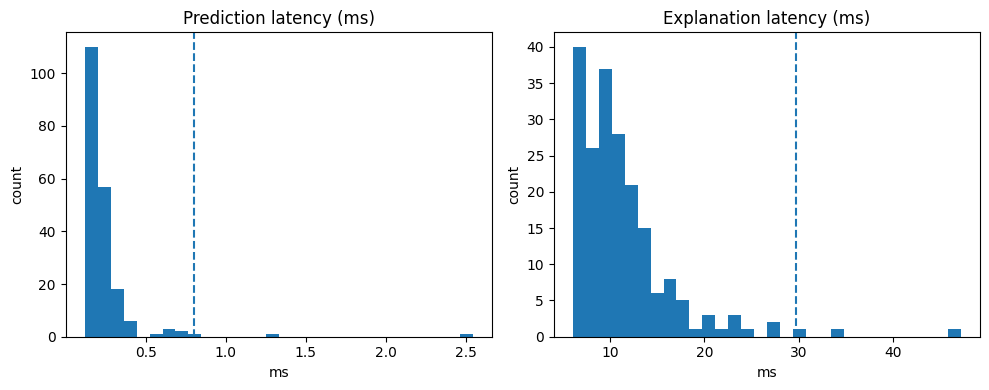

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

p99_pred = lat["pred_ms"].quantile(0.99)
p99_exp  = lat["exp_ms"].quantile(0.99)

fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(lat["pred_ms"], bins=30)
axes[0].axvline(p99_pred, linestyle="--")
axes[0].set_title("Prediction latency (ms)")
axes[0].set_xlabel("ms"); axes[0].set_ylabel("count")

axes[1].hist(lat["exp_ms"], bins=30)
axes[1].axvline(p99_exp, linestyle="--")
axes[1].set_title("Explanation latency (ms)")
axes[1].set_xlabel("ms"); axes[1].set_ylabel("count")

plt.tight_layout(); plt.show()


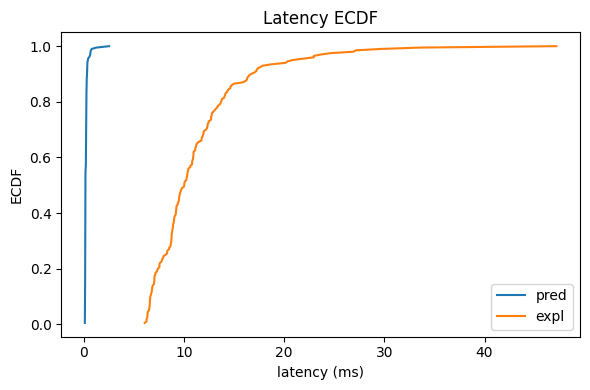

In [ ]:
def ecdf(x):
    x = np.sort(np.asarray(x))
    y = np.arange(1, len(x)+1) / len(x)
    return x, y

xp, yp = ecdf(lat["pred_ms"].values)
xe, ye = ecdf(lat["exp_ms"].values)

plt.figure(figsize=(6,4))
plt.plot(xp, yp, label="pred")
plt.plot(xe, ye, label="expl")
plt.xlabel("latency (ms)"); plt.ylabel("ECDF")
plt.legend(); plt.title("Latency ECDF"); plt.tight_layout(); plt.show()


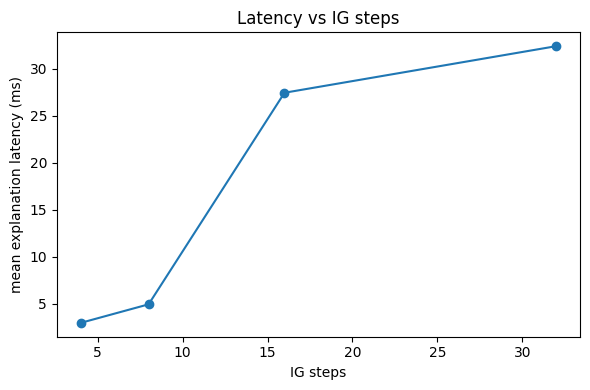

In [ ]:
import time
steps_list = [4, 8, 16, 32]
means = []
for s in steps_list:
    lat_s = bench_latencies(Xz.values, model, n=min(100, len(Xz)), steps=s)
    means.append(lat_s["exp_ms"].mean())

plt.figure(figsize=(6,4))
plt.plot(steps_list, means, marker="o")
plt.xlabel("IG steps"); plt.ylabel("mean explanation latency (ms)")
plt.title("Latency vs IG steps"); plt.tight_layout(); plt.show()


In [ ]:
class InferenceWrapper(torch.nn.Module):
    def __init__(self, m):
        super().__init__()
        self.m = m
    def forward(self, x: torch.Tensor):
        pd, attn = self.m(x)
        return pd, attn

wrapper = InferenceWrapper(model).eval()
example = torch.randn(1, d)
ts = torch.jit.trace(wrapper, example)

out_path = "./../serving/triton/rtxfair/1/model.pt"
os.makedirs(os.path.dirname(out_path), exist_ok=True)
ts.save(out_path)
out_path


'./../serving/triton/rtxfair/1/model.pt'